In [115]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from skimage.measure import compare_ssim as ssim
import matplotlib.pyplot as plt
import time
import os
import copy
import h5py
import sys
import math
import random
import torch
import numpy.polynomial.polynomial as poly
from PIL import Image
import gc

sys.path.append('../../../code')

from python.finetune_commons import show_images, ft_train_model, visualize_model
from python.commons import load_dict_from_hdf5, save_dict_to_hdf5, inc_inference_e2e, full_inference_e2e, adaptive_drilldown, generate_heatmap
from python.vgg16 import VGG16
from python.resnet18 import ResNet18

%matplotlib inline

In [102]:
image_size = 224

def inc_inference(model, image_file_path, beta, patch_size=4, stride=1,
                  adaptive=False, weights_data=None):
    if gpu:
        torch.cuda.synchronize()
    
    if not adaptive:
        with torch.no_grad():
            x = inc_inference_e2e(model, image_file_path, patch_size, stride,
                                  batch_size=256, beta=beta, gpu=gpu, version='v1',
                                  weights_data=weights_data, n_labels=2, c=0.5)
    
    if gpu:
        torch.cuda.synchronize()

    return x

loader = transforms.Compose([transforms.Resize([image_size, image_size]), transforms.ToTensor()])

In [108]:
gpu = True
image_size = 224

image_files = []
temp = os.listdir('../../../data/oct/DRUSEN_NORMAL/train/DRUSEN')
for name in temp:
    if name.endswith('jpeg'):
        image_files.append('../../../data/oct/DRUSEN_NORMAL/train/DRUSEN/'+name)
temp = os.listdir('../../../data/oct/DRUSEN_NORMAL/train/NORMAL')        
for name in temp:
    if name.endswith('jpeg'):
        image_files.append('../../../data/oct/DRUSEN_NORMAL/train/NORMAL/'+name)

        
file_amount = 10
image_files = random.sample(image_files, file_amount)
random.shuffle(image_files)

train_files = image_files[:file_amount//2]
test_files = image_files[file_amount//2:]

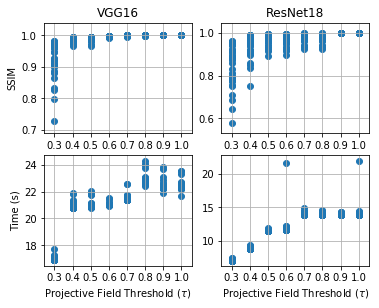

In [104]:
patch_size = 16
stride = 1

taus = [1.0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4]

plt.figure(figsize=(9,5))

i = 1

ssim_curve_fits = {}
time_curve_fits = {}

for model,model_name,weight_file in zip([VGG16, ResNet18], ['VGG16', 'ResNet18', 'ResNet18'],
    ['../../../code/python/vgg16_weights_ptch.h5', '../../../code/python/resnet18_weights_ptch.h5',
        '../../../code/python/resnet18_weights_ptch.h5']):
    
    weights_data = load_dict_from_hdf5(weight_file, gpu=gpu)
    temp_weights_data = load_dict_from_hdf5('../../../exps/oct_drusen_'+model_name.lower()+'_ptch.h5', gpu=gpu)
    
    if model_name == 'VGG16':
        weights_data['fc8_W:0'] = temp_weights_data['fc8_W:0']
        weights_data['fc8_b:0'] = temp_weights_data['fc8_b:0']
    else:
        weights_data['fc:w'] = temp_weights_data['fc:w']
        weights_data['fc:b'] = temp_weights_data['fc:b']

    x_vals = []
    y_ssim = []
    y_time = []
    
    for file_path in train_files:
        
        #x = full_inference_e2e(model, file_path, patch_size, stride, batch_size=128,
        #                       gpu=gpu, weights_data=weights_data, c=0.5, version='v1', n_labels=2)
        x = inc_inference(model, file_path, 1.0, patch_size=patch_size, stride=stride,
                             weights_data=weights_data)
        
        orig_hm = generate_heatmap(file_path, x, show=False, label="")
        
        for beta in taus:
            prev_time = time.time()
            x = inc_inference(model, file_path, beta, patch_size=patch_size, stride=stride,
                             weights_data=weights_data)
            inc_inference_time = time.time()-prev_time
            hm = generate_heatmap(file_path, x, show=False, label="")

            if hm.shape[0] < 7:
                win_size=3
            else:
                win_size=None
            
            ssim_value = ssim(orig_hm, hm, data_range=255, multichannel=True, win_size=win_size)
            x_vals.append(beta)
            y_ssim.append(ssim_value)
            y_time.append(inc_inference_time)
            
            gc.collect()
            torch.cuda.empty_cache()
    
    ssim_curve_fits[model_name] = poly.Polynomial(poly.polyfit(np.array(y_ssim), np.array(x_vals), 3))
    time_curve_fits[model_name] = poly.Polynomial(poly.polyfit(np.array(y_time), np.array(x_vals), 3))
            

    ax = plt.subplot(2,3,i)
    plt.scatter(x_vals, y_ssim)
    ax.set_title(model_name)
    
    plt.grid()
    plt.xticks(taus, taus)

    if i == 1:
        plt.ylabel('SSIM')
        
    ax = plt.subplot(2,3,i+3)
    plt.scatter(x_vals, y_time)
    
    plt.grid()
    plt.xlabel(r'$(\tau)$')
    plt.xticks(taus, taus)

    if i == 1:
        plt.ylabel('Time (s)')


    i = i + 1
    
plt.subplots_adjust(top=0.8)
plt.savefig('../images/ssim_tau.pdf', bbox_inches='tight')
plt.show()    

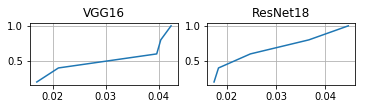

In [116]:
plt.figure(figsize=(9,2.5))

i = 1

for model,model_name,weight_file in zip([VGG16, ResNet18], ['VGG16', 'ResNet18', 'ResNet18'],
    ['../../../code/python/vgg16_weights_ptch.h5', '../../../code/python/resnet18_weights_ptch.h5',
        '../../../code/python/resnet18_weights_ptch.h5']):
    
    weights_data = load_dict_from_hdf5(weight_file, gpu=gpu)
    temp_weights_data = load_dict_from_hdf5('../../../exps/oct_drusen_'+model_name.lower()+'_ptch.h5', gpu=gpu)
    
    if model_name == 'VGG16':
        weights_data['fc8_W:0'] = temp_weights_data['fc8_W:0']
        weights_data['fc8_b:0'] = temp_weights_data['fc8_b:0']
    else:
        weights_data['fc:w'] = temp_weights_data['fc:w']
        weights_data['fc:b'] = temp_weights_data['fc:b']

    y_ssim = []
    
    ssim_threshold = 0.95

    ssim_tau = max(math.ceil(ssim_curve_fits[model_name](ssim_threshold)*10)/10, 0.4)

    for file_path in test_files:
        x = inc_inference(model, file_path, 1.0, patch_size=patch_size, stride=stride,
                             weights_data=weights_data)
        
        orig_hm = generate_heatmap(file_path, x, show=False, label="")
        
        x = inc_inference(model, file_path, ssim_tau, patch_size=patch_size, stride=stride,
                         weights_data=weights_data)
        hm = generate_heatmap(file_path, x, show=False, label="")

        if hm.shape[0] < 7:
            win_size=3
        else:
            win_size=None
        
        ssim_value = ssim(orig_hm, hm, data_range=255, multichannel=True, win_size=win_size)
        y_ssim.append(abs(ssim_value-ssim_threshold))
        
    ax = plt.subplot(2,3,i)
    unique, counts = np.unique(y_ssim, return_counts=True)
    
    plt.plot(unique, np.cumsum(counts)/np.sum(counts))
    
    ax.set_title(model_name)
    plt.grid()
    
    i+=1
    
plt.savefig('../images/ssim_cdf.pdf', bbox_inches='tight')    

In [112]:
ssim_curve_fits['VGG16'](1.0)

0.7730265792353634

In [97]:
ssim_tau

0.4